In [1]:
import os
path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)

# Water model development

The goal of this notebook is develop and improve the water model.

## Data

In [16]:
from data_utils.database import select_dataset
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import plotly.express as px

from data_utils.utils import data_dict_from_df_tables, get_X_y_from_data
from ggmodel_dev.validation import score_model_dictionnary, score_model, plot_diagnostic, make_baseline_computation_df, agg_score_by, model_validation_pipeline, export_to_xls
from ggmodel_dev.models.water.EW import model_dictionnary

plt.style.use('ggplot')

def prepare_water_model_data():

    # Select dataset
    df_tables = ["aquastat", 'worldbank', 'evapotranspiration', 'cropcalendar', 'efficientwater', 'sarahcrops']

    df_dictionnary = {df_table: select_dataset(df_table) for df_table in df_tables}

    # Preprocess some datasets
    df_dictionnary['cropcalendar'] = df_dictionnary['cropcalendar'].drop(columns=['Year'])
    df_dictionnary['aquastat'] = df_dictionnary['aquastat'][~df_dictionnary['aquastat'].Variable.isin(['CI', 'TC', 'ICA', 'AIR'])]
    df_dictionnary['sarahcrops'] = df_dictionnary['sarahcrops'][~df_dictionnary['sarahcrops'].Variable.isin(['ICA', 'CI'])]


    # Convert to model readable datadict
    data_dict = data_dict_from_df_tables([df for _, df in df_dictionnary.items()])

    ISOs = df_dictionnary['aquastat'].ISO.unique()
    
    # Impute missing values
    def preprocess_dict_item(key, value):
        mux = pd.MultiIndex.from_product([ISOs, range(2000, 2020)],
                                     names=['ISO', 'Year'])

        if key in ['ICA', 'Kc']:
            return value
        else:
            return (
                  value.reindex(mux)
                      .groupby(level='ISO')
                      .fillna(method='ffill')
                      .groupby(level='ISO')
                      .fillna(method='bfill')
                      .fillna(0))


    data_dict = {k: preprocess_dict_item(k, v).sort_index() for k, v in data_dict.items()} # comment here for raw data

    return data_dict

data_dict = prepare_water_model_data()

## Model

In [17]:
scores = score_model_dictionnary(model_dictionnary, data_dict)

IWW_model: Done
EW1_partial_model: Done
EW2_partial_model: Done
EW1_model: 

/home/simon/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Done
EW2_model: 

/home/simon/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Done
EW_model: 

/home/simon/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Done


In [18]:
scores['EW1_model']['score_by_Variable']

,r2,correlation,rmse
Variable,,,
AWU,0.625183,0.930965,193.370224
EW1,0.740937,0.861138,936.434440
IWR,0.673832,0.959427,49.031668
IWW,-0.137856,0.345620,194.301120
MWU,0.868027,0.937411,0.966363
TWW,0.710469,0.939063,209.341169


In [19]:
scores['EW1_model']['score_by_ISO_Variable'].loc['FRA']

,r2,correlation,rmse
Variable,,,
AWU,0.194690,0.876024,0.264556
EW1,0.781499,0.933875,21.235475
IWR,0.000000,NaN,0.041338
IWW,-0.525679,0.852289,1.015427
MWU,-71.326984,-0.932439,6.800026
TWW,-0.819952,0.971560,10.611801


In [20]:
result_dfs = model_validation_pipeline(model_dictionnary['EW_model'], data_dict)
export_to_xls(result_dfs, 'data/EW_model.xlsx')

/home/simon/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/simon/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [21]:
for name, series in data_dict.items():
    series.to_csv(f'data/EW/{name}.csv')

## Scenario

In [22]:
from ggmodel_dev.models.water import EW_scenario 
from ggmodel_dev.projection import run_scenario_list 

ISO_data_dict = {k: v.loc[['FRA'], :] for k, v in data_dict.items()}

list_of_scenarios = [dict(WP_rate=1.05, WRR_rate=1.01),
                     dict(WP_rate=1.1, WRR_rate=1.01),
                     dict(WP_rate=0.9, WRR_rate=1.01)]

simulation_results = run_scenario_list(scenario_function=EW_scenario.run_scenario,
                                       list_of_scenarios=list_of_scenarios,
                                       projection_dictionnary=EW_scenario.projection_dict,
                                       data_dict=ISO_data_dict
                                      )

/home/simon/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/home/simon/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/home/simon/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/home/simon/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/home/simon/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


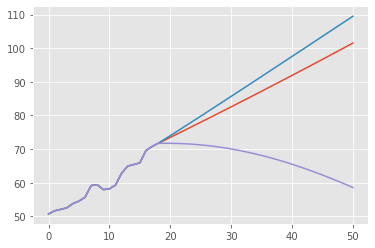

In [23]:
plt.plot(simulation_results['scenario_0']['EW1'].values)
plt.plot(simulation_results['scenario_1']['EW1'].values)
plt.plot(simulation_results['scenario_2']['EW1'].values)